In [10]:
# ssh variables

import os
from sshtunnel import SSHTunnelForwarder
import pg as db
import pandas as pd
import re
from sqlalchemy import create_engine
import numpy as np
import plotly as plotly
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
%matplotlib inline

host = 'prd-db.spot-internal'
localhost = '127.0.0.1'
ssh_username = os.environ['SPOT_SSH_USER']
ssh_private_key = '/Users/david/.ssh/id_rsa'
ssh_private_key_pwd = os.environ['SSH_PWD']

intermediary=os.environ['SPOT_SSH_SERVER']
user=os.environ['SPOT_DB_USER']
password=os.environ['SPOT_DB_PW']

database='trace_wood_delawareconnector'

def query(q):
    with SSHTunnelForwarder(
    (intermediary, 22), 
    ssh_username=ssh_username,
    ssh_pkey=ssh_private_key, 
    ssh_private_key_password=ssh_private_key_pwd,
    remote_bind_address=(host,5432)) as server:

        connstring = 'postgresql://{user}:{pwd}@{host}:{localport}/{database}'.format(
            user=user,
            pwd=password,
            host=localhost,
            localport=server.local_bind_port,
            database=database)
        
        engine = create_engine(connstring)

        try:
            result = pd.read_sql_query(q, engine)
        finally:
            engine.dispose()

        return result;

In [16]:
df = query("with raw_values as (select distinct entity_id, field, new_value, \
max(created_at) over (partition by entity_id,new_value) \
 from audit_log where field = 'stage' and new_value is not null and entity_type = 'pipe') \
 select *, row_number() over (partition by new_value order by max asc) From raw_values")

In [3]:
df.head()

,entity_id,field,new_value,max,row_number
0,41c19d45-dd6d-4097-b64a-2442265649ae,stage,"""Cut Out""",2019-05-19 15:13:06.100000+00:00,1
1,16d8195e-f956-46ac-937f-2433fce49334,stage,"""Cut Out""",2019-05-19 15:15:29.600000+00:00,2
2,fa3827da-d2f6-4d6a-88f3-cf51688511cb,stage,"""Cut Out""",2019-05-19 18:43:29.800000+00:00,3
3,81b4ec38-4819-497b-aa50-6949f7b0a751,stage,"""Cut Out""",2019-05-19 19:22:10.900000+00:00,4
4,500739c3-a353-427b-8458-9df5a3a4551e,stage,"""Cut Out""",2019-05-19 19:22:38.800000+00:00,5


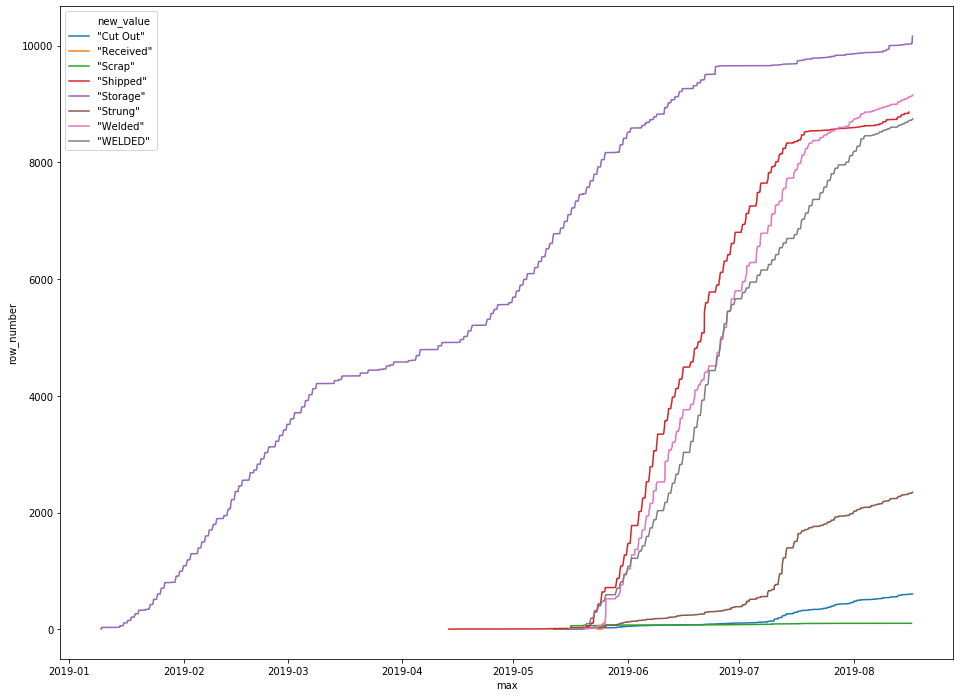

In [15]:
plt.figure(figsize=(16,12))
sns.lineplot(x='max',y='row_number',hue='new_value',data=df)